# GMVAE Evaluation

This section would focus on solving most of the questions that are regarding Q1. <br>

In [49]:
import torch
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow

from utils import tools 
from utils.models.gmvae import GMVAE
from utils.train import train


# Import the necessary modules
from utils import CXReader, DfReader

### Assign paths here

In [50]:
#Path to assign tests (copy path directly)
work_path = r"D:\Python_Projects\CS236-Final-Proj\src"
device = "cpu"
#Set the path to this working directory
os.chdir(work_path)
print(os.getcwd())

# Create the data path
data_path = os.path.join(os.getcwd(), os.pardir, "data")

D:\Python_Projects\CS236-Final-Proj\src


### Set the dataframes

In [51]:
#Create a dataframe compiler
df_compiler = DfReader()

#set the path and retrieve the dataframes
df_compiler.set_folder_path(data_path)

#Get the dataframe holder and names
dfs_holder, dfs_names = df_compiler.get_dfs()

  0%|          | 0/112124 [00:00<?, ?it/s]

100%|█████████▉| 112121/112124 [00:00<00:00, 879057.81it/s]

The file: miccai2023_nih-cxr-lt_labels_test.csv has been retrieved


100%|██████████| 112124/112124 [00:00<00:00, 274060.71it/s]

The file: miccai2023_nih-cxr-lt_labels_train.csv has been retrieved
The file: miccai2023_nih-cxr-lt_labels_val.csv has been retrieved


### Set the data with all required transformation

In [52]:
# Define mean and std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define a transformation for converting and normalizing images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.CenterCrop((224, 224)),  # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Apply mean and std normalization
])
#Create datasets and dataloaders, with batch size of 16, and shuffle true, and num workers = 4
test_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[0], transform=transform, device=device)
train_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[1], transform=transform, device=device)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

### Set the test images with all required labels

In [53]:
#Create a labeled_subset tuple by iterating through 100 values of test dataset
test_images = []
test_labels = []
print("Loading labeled subset...")
for i in range(100):
    #Sampled images from train to see single shape
    test_image, test_label = test_dataset[i]
    test_images.append(test_image)
    test_labels.append(test_label)

# Convert the list of tensors to a tensor of tensors
test_images= torch.stack(test_images, dim=0)
test_labels= torch.stack(test_labels, dim=0)
labeled_subset = (test_images, test_labels)
print("Getting labeled subset")

Loading labeled subset...


Getting labeled subset


In [62]:
#Z space like run gmvae
z = 20
k = 500
run = 0
global_num = 2000

layout = [
    ('model={:s}',  'gmvae'),
    ('z={:02d}',  z),
    ('k={:03d}',  k),
    ('run={:04d}', run)
]
model_name = '_'.join([t.format(v) for (t, v) in layout])
print('Model name:', model_name)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gmvae = GMVAE(z_dim=z, k=k, name=model_name).to(device)

tools.load_model_by_name(gmvae, global_step=global_num)

Model name: model=gmvae_z=20_k=500_run=0000
Loaded from D:\Python_Projects\CS236-Final-Proj\src\checkpoints\model=gmvae_z=20_k=500_run=0000\model-02000.pt


In [56]:
tools.evaluate_lower_bound(gmvae, labeled_subset, run_iwae=False)

********************************************************************************
LOG-LIKELIHOOD LOWER BOUNDS ON TEST SUBSET
********************************************************************************
estimate of metrics:...1
estimate of metrics:...2
NELBO: -2.512904413346005e+18. KL: 127481298944.0. Rec: -2.512904413346005e+18


### Create a code that plots an image

In [58]:
def show_image(image, name_img: str):
    """
    Instance method that would plot an
    image to see if the dataset is properly set.
    """
    f, ax1 = plt.subplots(1, 1)
    ax1.set_title('Desired image ' + name_img)
    ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

torch.Size([3, 224, 224])


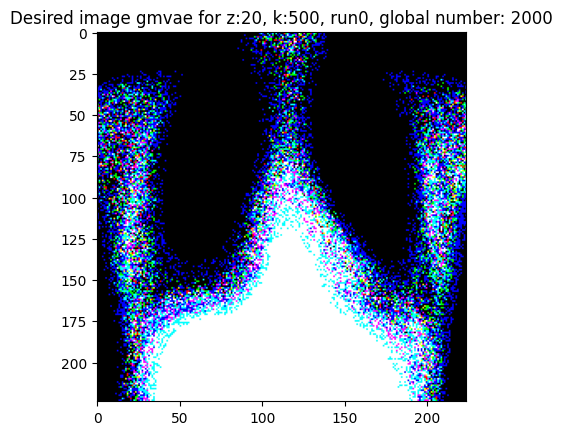

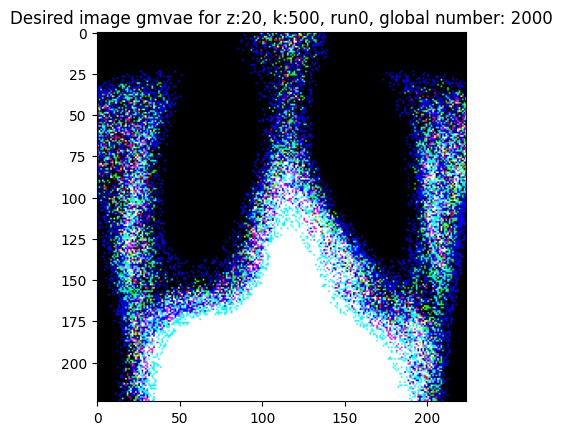

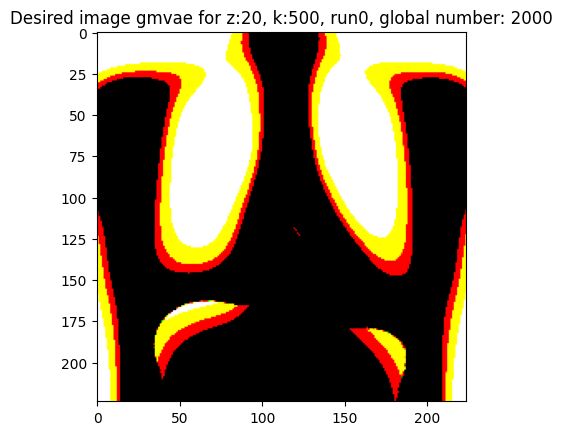

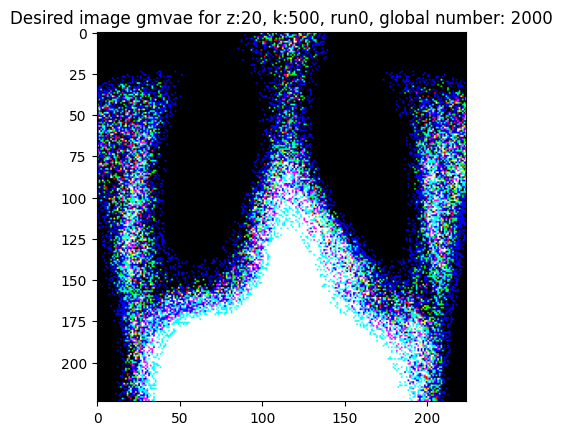

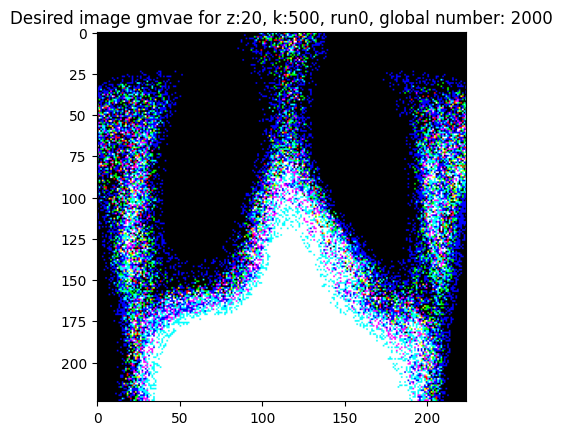

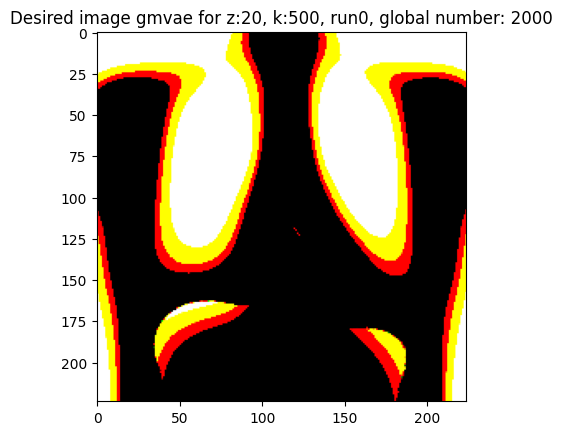

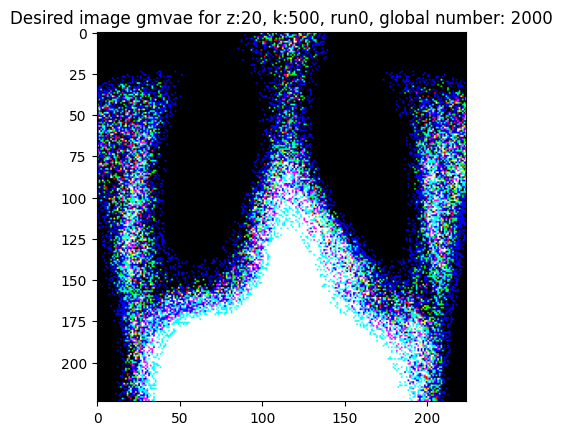

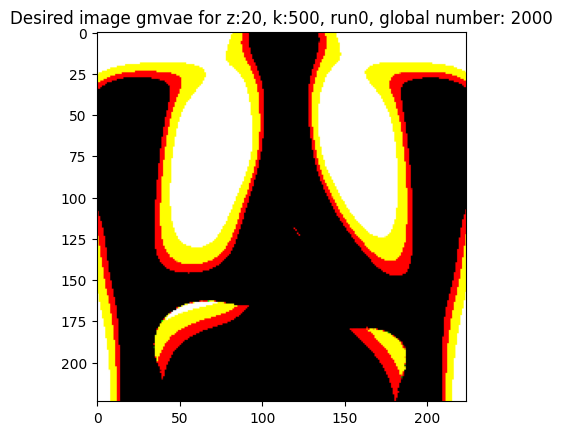

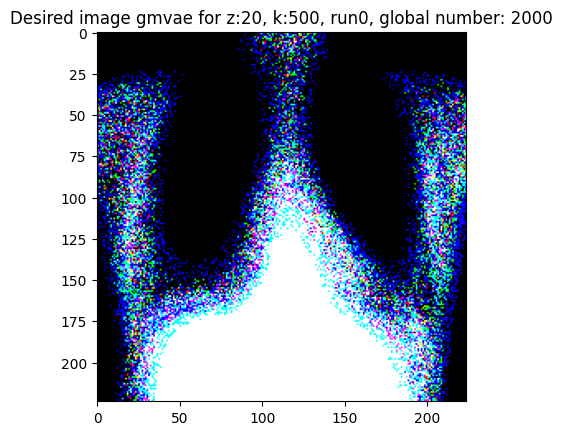

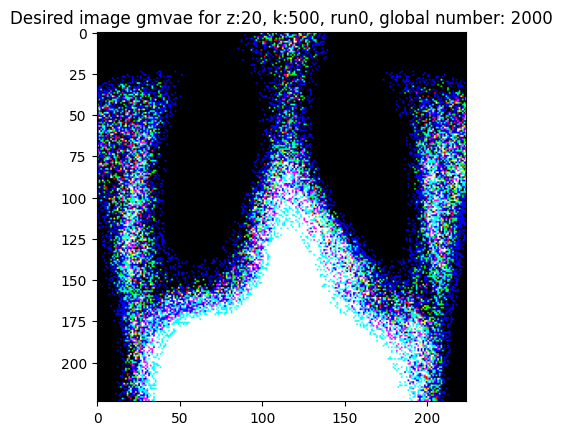

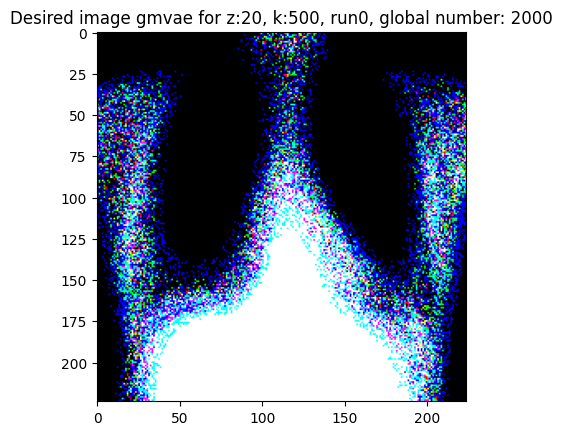

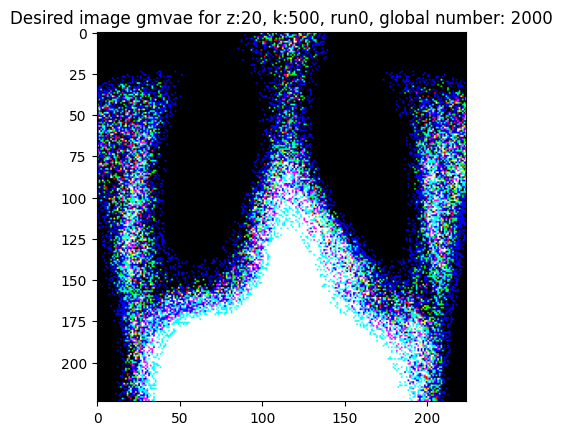

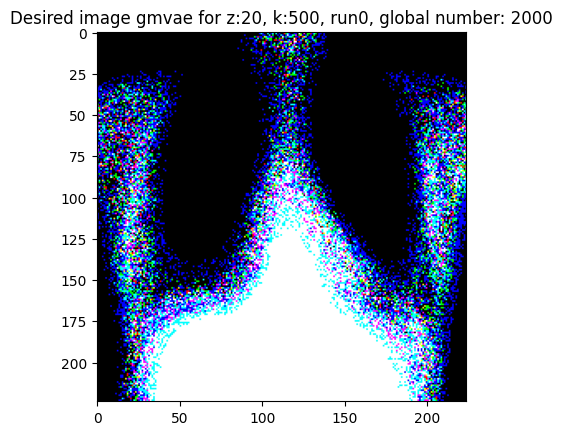

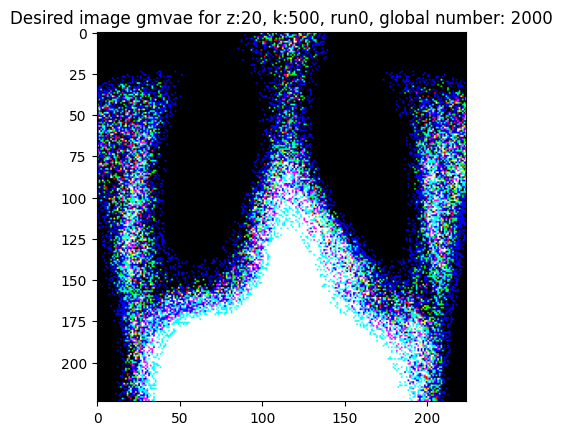

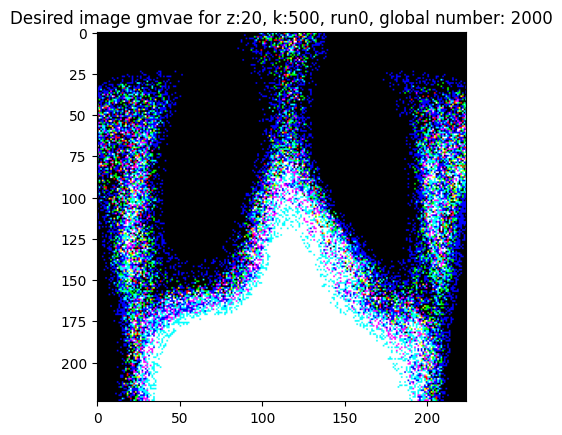

In [63]:
#Batch number
batch_num = 15

samples = gmvae.sample_x(batch_num).reshape(batch_num,3,224,224).cpu()

#grid = make_grid(samples, nrow=20)
#imshow(grid.permute(1,2,0))
print(samples[2].shape)
for idx in range(batch_num):
    show_image(samples[idx].detach(), f"gmvae for z:{z}, k:{k}, run{run}, global number: {global_num}")